## This is Owen Monroe's Notebook for the IS 567 Text Mining Final Project - Newspaper and Hand Annotation Comparison
This notebook evaluates NER models and tagging, comparing the newspaper historical NER model to my own hand-annotated data. The "newspaper" model was found on huggingface and is trained on historical english language newspapers. The text data comes from downloaded files from the Hathi-Trust Digital Library. These texts are 19th Century Magazines from the publishers, The Society for the Diffusion of Useful Knowledge, the William and Robert Chambers, and the Society for the Diffusion of Christian and General Knowledge among the Chinese. 

In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("dell-research-harvard/historical_newspaper_ner")
model = AutoModelForTokenClassification.from_pretrained("dell-research-harvard/historical_newspaper_ner")

/Users/owenmonroe/anaconda3/envs/textmining/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config = model.config
labels = config.id2label
print(labels)

{0: 'B-LOC', 1: 'B-MISC', 2: 'B-ORG', 3: 'B-PER', 4: 'I-LOC', 5: 'I-MISC', 6: 'I-ORG', 7: 'I-PER', 8: 'O'}


In [4]:
# Building Model

import torch

tokenizer = AutoTokenizer.from_pretrained("dell-research-harvard/historical_newspaper_ner")
model = AutoModelForTokenClassification.from_pretrained("dell-research-harvard/historical_newspaper_ner")

inputs = tokenizer(
    "HuggingFace is a company based in Paris and New York", add_special_tokens=False, return_tensors="pt"
)

with torch.no_grad():
    logits = model(**inputs).logits

predicted_token_class_ids = logits.argmax(-1)

# Note that tokens are classified rather then input words which means that
# there might be more predicted token classes than words.
# Multiple token classes might account for the same word
predicted_tokens_classes = [model.config.id2label[t.item()] for t in predicted_token_class_ids[0]]
predicted_tokens_classes
# ['O', 'ORG', 'ORG', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'LOC', 'LOC']

labels = predicted_token_class_ids
# loss = model(**inputs, labels=labels).loss
# round(loss.item(), 2)
# 0.01

In [5]:
# Creating a Function to merge BIO tokens into a single span token

def merge_iob_tokens(annotations):
    merged_annotations = []
    current_entity = None
    current_tokens = []

    for token, label in annotations:
        iob_prefix, entity = label.split('-')
        
        if iob_prefix == 'B':
            # Start a new entity
            if current_entity:
                merged_annotations.append((' '.join(current_tokens), current_entity))
            current_entity = entity
            current_tokens = [token]
        elif iob_prefix == 'I':
            # Continue the current entity
            if current_entity == entity:
                current_tokens.append(token)
            else:
                # Start a new entity if the entity type changes
                if current_entity:
                    merged_annotations.append((' '.join(current_tokens), current_entity))
                current_entity = entity
                current_tokens = [token]

    # Append the last entity if any
    if current_entity:
        merged_annotations.append((' '.join(current_tokens), current_entity))

    return merged_annotations

In [6]:
# Creating a function to keep GPE, LOC, ORG, PERSON tags while mapping GPE to LOC and PERSON to PER to match across annotations

def filter_map_tags(hand_annotations):

    tags_to_preserve = ['GPE', 'LOC', 'ORG', 'PERSON']
    filtered_hand = [(token, tag) for token, tag in hand_annotations if tag in tags_to_preserve]
   
    tag_mapping_1 = {'GPE': 'LOC'} 
    first_filtered = [(token, tag_mapping_1.get(tag, tag)) for token, tag in filtered_hand]

    tag_mapping_2 = {'PERSON': 'PER'}
    second_filtered = [(token, tag_mapping_2.get(tag, tag)) for token, tag in first_filtered]
    hand_annotations_cleaned = second_filtered
    
    return hand_annotations_cleaned

In [7]:
# Creating a function to get filtered hand annotations from file

def get_hand_subset_annotations(hand_file_path):

    hand_annotated_data = []
    with open(hand_file_path, "r", encoding="utf-8") as iob_file:
        for line in iob_file:
            line = line.strip()
            if line:
                token, label = line.split("\t")
           
                hand_annotated_data.append((token, label))

                hand_subset = hand_annotated_data[:512]


    hand_annotated_tagged = [(token, label) for token, label in hand_subset if label != 'O']

    merged_hand_annotations = merge_iob_tokens(hand_annotated_tagged)

    filtered_hand_annotations = filter_map_tags(merged_hand_annotations)
    
    return filtered_hand_annotations


In [8]:
# Creating a function to get newspaper ner annotations from file

def get_newspaper_annotations(text_file_path):

    with open(text_file_path, "r", encoding="utf-8") as text_file:
        text = text_file.read()

    subset_text = text[:512]

    tokenizer = AutoTokenizer.from_pretrained("dell-research-harvard/historical_newspaper_ner")
    model = AutoModelForTokenClassification.from_pretrained("dell-research-harvard/historical_newspaper_ner")

    inputs = tokenizer(
        subset_text, add_special_tokens=False, return_tensors="pt"
    )

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_token_class_ids = logits.argmax(-1)

    predicted_tokens_classes = [model.config.id2label[t.item()] for t in predicted_token_class_ids[0]]


    labels = predicted_token_class_ids

    text_list = subset_text.split()

    newspaper_annotations = list(zip(text_list, predicted_tokens_classes))

    filled_newspaper_annotations = [item for item in newspaper_annotations if item[1] not in ('O', 'B-MISC', 'I-MISC')]

    newspaper_annotations_filtered = merge_iob_tokens(filled_newspaper_annotations)

    return newspaper_annotations_filtered



In [9]:
# Creating a Function to Produce Reports by Label

def get_reports_by_label(pos_neg):
    tag_lists = {}

    # Organize tuples into separate lists based on tags
    for token, tag in pos_neg:
        if tag not in tag_lists:
            tag_lists[tag] = [(token, tag)]
        else:
            tag_lists[tag].append((token, tag))

    # Convert the dictionaries to lists
    lists_by_tag = list(tag_lists.values())

# Print the lists organized by tag
    for tag_list in lists_by_tag:
        print(f"{tag_list[0][1]}, {len(tag_list)} Total : ", tag_list)

## Document 1 Comparison: Clipping from Chambers's Journal 1835 (on France)

In [10]:
hand_annotations_filtered_1 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/Chambers_InfoForPeople_France_1835.txt.tsv')
hand_annotations_filtered_1

[('France', 'LOC'),
 ('Jura mountains', 'LOC'),
 ('Daaphlny', 'LOC'),
 ('Provence', 'LOC'),
 ('mountains of Auvergne', 'LOC'),
 ('Puy de Dome', 'LOC'),
 ("Moots d'Or", 'LOC'),
 ('Mont Lozcre', 'LOC'),
 ('Pyrenees', 'LOC'),
 ('France', 'LOC'),
 ('Spain', 'LOC'),
 ('Rhine', 'LOC'),
 ('Seine', 'LOC'),
 ('Loire', 'LOC'),
 ('Garonne', 'LOC'),
 ('Adour', 'LOC'),
 ('Pyrenees', 'LOC'),
 ('Bayonne', 'LOC'),
 ('Marne', 'LOC'),
 ('Oise', 'LOC'),
 ('Seine', 'LOC'),
 ('Loire', 'LOC'),
 ('Sarthe', 'LOC'),
 ('Maycnne', 'LOC'),
 ('Loire', 'LOC'),
 ('Rhone', 'LOC'),
 ('Saoue', 'LOC'),
 ('Isire', 'LOC'),
 ('Durance', 'LOC'),
 ('Ain', 'LOC'),
 ('Sorgue', 'LOC'),
 ('Tarn', 'LOC'),
 ('Dordi', 'LOC'),
 ('Garonne', 'LOC'),
 ('France', 'LOC'),
 ('Flanders', 'LOC'),
 ('Artuis', 'LOC'),
 ('Picardy', 'LOC'),
 ('Normandy', 'LOC'),
 ('Isle of France', 'LOC'),
 ('Ga - ronne', 'LOC'),
 ('Languedoc', 'LOC'),
 ('Limarne', 'LOC'),
 ('Auvergne', 'LOC'),
 ('provinces', 'LOC')]

In [11]:
newspaper_annotations_filtered_1 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/Chambers_InfoForPeople_France_1835.txt')
newspaper_annotations_filtered_1

[('France', 'LOC'), ('the', 'LOC'), ('north-east. They are of the', 'LOC')]

Doc 1 (Chambers's Information for the People 1835) EVALUATION REPORTS : HAND AND NEWSPAPER NER ANNOTATION SUBSETS

Micro PRECISION score for subsets = 1.0
Weighted PRECISION score for subsets = 1.0

Micro RECALL score for subsets = 1.0
Weighted RECALL score for subsets = 1.0

Micro F1 score for subsets = 1.0
Weighted F1 score for subsets = 1.0

Individual label performance: 
Accuracy score:  1.0
              precision    recall  f1-score   support

         LOC       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



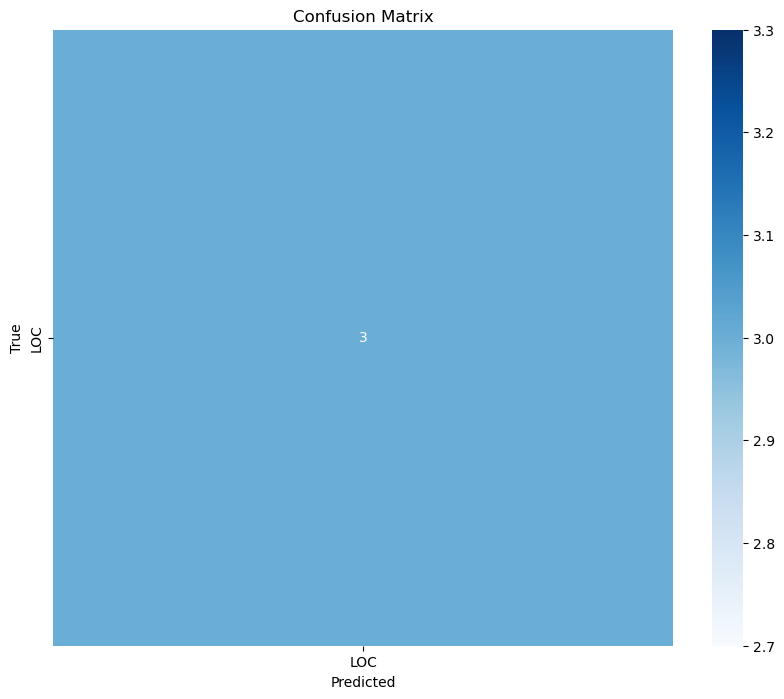

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix


y_true = [label for token, label in hand_annotations_filtered_1[:3]]
y_pred = [label for token, label in newspaper_annotations_filtered_1]

prec_score_micro = precision_score(y_true, y_pred, average='micro')
prec_score_weighted = precision_score(y_true, y_pred, average='weighted')

rec_score_micro = recall_score(y_true, y_pred, average='micro')
rec_score_weighted = recall_score(y_true, y_pred, average='weighted')

f1_score_micro = f1_score(y_true, y_pred, average='micro')
f1_score_weighted = f1_score(y_true, y_pred, average='weighted')


print("Doc 1 (Chambers's Information for the People 1835) EVALUATION REPORTS : HAND AND NEWSPAPER NER ANNOTATION SUBSETS")
print()
print(f'Micro PRECISION score for subsets = {prec_score_micro}')
print(f'Weighted PRECISION score for subsets = {prec_score_weighted}')
print()
print(f'Micro RECALL score for subsets = {rec_score_micro}')
print(f'Weighted RECALL score for subsets = {rec_score_weighted}')
print()
print(f'Micro F1 score for subsets = {f1_score_micro}')
print(f'Weighted F1 score for subsets = {f1_score_weighted}')
print()
print ("Individual label performance: ")
print ("Accuracy score: ", accuracy_score(y_true, y_pred))
print (classification_report(y_true, y_pred))


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


labels = sorted(list(set(y_true + y_pred)))

conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
ground_truth_set = set(hand_annotations_filtered_1)
ner_predictions_set = set(newspaper_annotations_filtered_1)

true_positives = ground_truth_set.intersection(ner_predictions_set)

num_true_positives = len(true_positives)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives} in Document 1 - Chambers's Information for the People 1835")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives)
print()
print('Total True Positives:')

for entity in true_positives:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 1 in Document 1 - Chambers's Information for the People 1835

True Positives By Label:
LOC, 1 Total :  [('France', 'LOC')]

Total True Positives:
True Positive: ('France', 'LOC')


In [14]:
false_negatives = ground_truth_set.difference(ner_predictions_set)

num_false_negatives = len(false_negatives)
print('False Negatvies are present in hand truth but not ner predictions')
print(f"Number of False Negatives: {num_false_negatives} in Document 1 - Chambers's Information for the People 1835")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives)
print()
print('Total False Negatives:')

for entity in false_negatives:
    print(f"False Negative : {entity}")

False Negatvies are present in hand truth but not ner predictions
Number of False Negatives: 37 in Document 1 - Chambers's Information for the People 1835

False Negatives By Label:
LOC, 37 Total :  [('Isle of France', 'LOC'), ('Daaphlny', 'LOC'), ('Languedoc', 'LOC'), ('Jura mountains', 'LOC'), ('Bayonne', 'LOC'), ('Ain', 'LOC'), ('Maycnne', 'LOC'), ('Flanders', 'LOC'), ("Moots d'Or", 'LOC'), ('Loire', 'LOC'), ('Dordi', 'LOC'), ('Mont Lozcre', 'LOC'), ('Sarthe', 'LOC'), ('Isire', 'LOC'), ('Saoue', 'LOC'), ('Sorgue', 'LOC'), ('Ga - ronne', 'LOC'), ('Rhine', 'LOC'), ('Puy de Dome', 'LOC'), ('Marne', 'LOC'), ('Oise', 'LOC'), ('Durance', 'LOC'), ('Artuis', 'LOC'), ('Provence', 'LOC'), ('Seine', 'LOC'), ('Rhone', 'LOC'), ('Tarn', 'LOC'), ('mountains of Auvergne', 'LOC'), ('Picardy', 'LOC'), ('Normandy', 'LOC'), ('Garonne', 'LOC'), ('Limarne', 'LOC'), ('Adour', 'LOC'), ('Spain', 'LOC'), ('Auvergne', 'LOC'), ('provinces', 'LOC'), ('Pyrenees', 'LOC')]

Total False Negatives:
False Negative : 

In [15]:
false_positives = ner_predictions_set.difference(ground_truth_set)


num_false_positives = len(false_positives)
print('False Positives are predicted by ner but are not in hand truth')
print(f"Number of False Positives: {num_false_positives} in Document 1 - Chambers's Information for the People 1835")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives)
print()
print('Total False Positives:')

for entity in false_positives:
    print(f"False Positive : {entity}")

False Positives are predicted by ner but are not in hand truth
Number of False Positives: 2 in Document 1 - Chambers's Information for the People 1835

False Positives By Label:
LOC, 2 Total :  [('the', 'LOC'), ('north-east. They are of the', 'LOC')]

Total False Positives:
False Positive : ('the', 'LOC')
False Positive : ('north-east. They are of the', 'LOC')


In [16]:
rec_calc = num_true_positives / (num_true_positives + num_false_negatives)
prec_calc = num_true_positives / (num_true_positives + num_false_positives)
f1_calc = (2 * prec_calc * rec_calc) / (prec_calc + rec_calc)

print("Evaluation Calculation Reports for Document 1 - Chambers's Information for the People 1835")
print()
print(f'Recall Score = {rec_calc}')
print(f'Precision Score = {prec_calc}')
print(f'F1 Score = {f1_calc}')


Evaluation Calculation Reports for Document 1 - Chambers's Information for the People 1835

Recall Score = 0.02631578947368421
Precision Score = 0.3333333333333333
F1 Score = 0.048780487804878044


## Document 2 Comparison: Clipping from Chambers's Journal 1839 (on Literature)


In [17]:
hand_annotations_filtered_2 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/Chambers_Journal_literature_Jan26_1839.txt.tsv')
hand_annotations_filtered_2

[('EDINBURGIT', 'LOC'),
 ('CHAMBERS', 'PER'),
 ('WILLIAM', 'PER'),
 ('ROBERT CHAMBERS', 'PER'),
 ('CHAMBERS', 'PER'),
 ('BRADBURY', 'PER'),
 ('EVANS', 'PER'),
 ('WHITEFRIARS', 'LOC'),
 ('Fielding', 'PER'),
 ('Smollett', 'PER'),
 ('Parson Adams', 'PER'),
 ('Lilliputians', 'ORG'),
 ('Lilliput', 'LOC')]

In [18]:
newspaper_annotations_filtered_2 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/Chambers_Journal_literature_Jan26_1839.txt')
newspaper_annotations_filtered_2

[('ROBERT', 'LOC'),
 ('CHAMBERS,', 'LOC'),
 ('FOR', 'PER'),
 ('THE PEOPLE," “', 'PER'),
 ('LONDON. NUMBER 365.', 'PER'),
 ('JANUARY 26, 1839. PRICE THREE HALFPENSE.', 'PER'),
 ('loads of meat, for', 'PER'),
 ('suppose that it must', 'PER')]

Doc 2 (Chambers's Journal 1839) EVALUATION REPORTS : HAND AND SPACY NER ANNOTATION SUBSETS

Micro PRECISION score for subsets = 0.75
Weighted PRECISION score for subsets = 0.75

Micro RECALL score for subsets = 0.75
Weighted RECALL score for subsets = 0.75

Micro F1 score for subsets = 0.75
Weighted F1 score for subsets = 0.75

Individual label performance: 
Accuracy score:  0.75
              precision    recall  f1-score   support

         LOC       0.50      0.50      0.50         2
         PER       0.83      0.83      0.83         6

    accuracy                           0.75         8
   macro avg       0.67      0.67      0.67         8
weighted avg       0.75      0.75      0.75         8



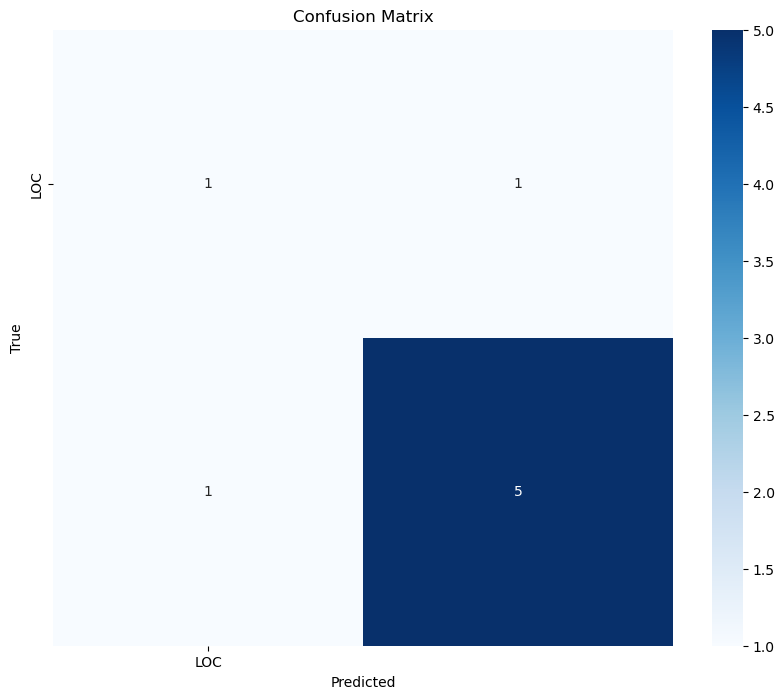

In [19]:

second_hand_subset_2 = hand_annotations_filtered_2[:8]
second_newpapers_subset_2 = newspaper_annotations_filtered_2

y_true_2 = [label for token, label in second_hand_subset_2]
y_pred_2 = [label for token, label in second_newpapers_subset_2]

prec_score_micro_2 = precision_score(y_true_2, y_pred_2, average='micro')
prec_score_weighted_2 = precision_score(y_true_2, y_pred_2, average='weighted')

rec_score_micro_2 = recall_score(y_true_2, y_pred_2, average='micro')
rec_score_weighted_2 = recall_score(y_true_2, y_pred_2, average='weighted')

f1_score_micro_2 = f1_score(y_true_2, y_pred_2, average='micro')
f1_score_weighted_2 = f1_score(y_true_2, y_pred_2, average='weighted')

print("Doc 2 (Chambers's Journal 1839) EVALUATION REPORTS : HAND AND SPACY NER ANNOTATION SUBSETS")
print()
print(f'Micro PRECISION score for subsets = {prec_score_micro_2}')
print(f'Weighted PRECISION score for subsets = {prec_score_weighted_2}')
print()
print(f'Micro RECALL score for subsets = {rec_score_micro_2}')
print(f'Weighted RECALL score for subsets = {rec_score_weighted_2}')
print()
print(f'Micro F1 score for subsets = {f1_score_micro_2}')
print(f'Weighted F1 score for subsets = {f1_score_weighted_2}')
print()
print ("Individual label performance: ")
print ("Accuracy score: ", accuracy_score(y_true_2, y_pred_2))
print (classification_report(y_true_2, y_pred_2))



labels_2 = sorted(list(set(y_true_2 + y_pred_2)))

conf_matrix_2 = confusion_matrix(y_true_2, y_pred_2, labels=labels_2)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
ground_truth_set_2 = set(hand_annotations_filtered_2)
newspaper_predictions_set_2 = set(newspaper_annotations_filtered_2)

true_positives_2 = ground_truth_set_2.intersection(newspaper_predictions_set_2)

num_true_positives_2 = len(true_positives_2)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_2} in Document 2 - Chambers's Journal 1839")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_2)
print()
print('Total True Positives:')

for entity in true_positives_2:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 2 - Chambers's Journal 1839

True Positives By Label:

Total True Positives:


In [21]:
false_negatives_2 = ground_truth_set_2.difference(newspaper_predictions_set_2)

num_false_negatives_2 = len(false_negatives_2)
print('False Negatives are present in hand truth but not newspaper model predictions')
print(f"Number of False Negatives: {num_false_negatives_2} in Document 2 - Chambers's Journal 1839")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_2)
print()
print('Total False Negatives:')

for entity in false_negatives_2:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not newspaper model predictions
Number of False Negatives: 12 in Document 2 - Chambers's Journal 1839

False Negatives By Label:
PER, 8 Total :  [('EVANS', 'PER'), ('Smollett', 'PER'), ('Fielding', 'PER'), ('CHAMBERS', 'PER'), ('BRADBURY', 'PER'), ('Parson Adams', 'PER'), ('ROBERT CHAMBERS', 'PER'), ('WILLIAM', 'PER')]
ORG, 1 Total :  [('Lilliputians', 'ORG')]
LOC, 3 Total :  [('Lilliput', 'LOC'), ('EDINBURGIT', 'LOC'), ('WHITEFRIARS', 'LOC')]

Total False Negatives:
False Negative : ('EVANS', 'PER')
False Negative : ('Lilliputians', 'ORG')
False Negative : ('Lilliput', 'LOC')
False Negative : ('Smollett', 'PER')
False Negative : ('Fielding', 'PER')
False Negative : ('EDINBURGIT', 'LOC')
False Negative : ('CHAMBERS', 'PER')
False Negative : ('WHITEFRIARS', 'LOC')
False Negative : ('BRADBURY', 'PER')
False Negative : ('Parson Adams', 'PER')
False Negative : ('ROBERT CHAMBERS', 'PER')
False Negative : ('WILLIAM', 'PER')


In [22]:
false_positives_2 = newspaper_predictions_set_2.difference(ground_truth_set)

num_false_positives_2 = len(false_positives_2)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_2} in Document 2 - Chambers's Journal 1839")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_2)
print()
print('Total False Positives:')

for entity in false_positives_2:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 8 in Document 2 - Chambers's Journal 1839

False Positives By Label:
PER, 6 Total :  [('suppose that it must', 'PER'), ('loads of meat, for', 'PER'), ('THE PEOPLE," “', 'PER'), ('FOR', 'PER'), ('JANUARY 26, 1839. PRICE THREE HALFPENSE.', 'PER'), ('LONDON. NUMBER 365.', 'PER')]
LOC, 2 Total :  [('CHAMBERS,', 'LOC'), ('ROBERT', 'LOC')]

Total False Positives:
False Positive : ('suppose that it must', 'PER')
False Positive : ('loads of meat, for', 'PER')
False Positive : ('THE PEOPLE," “', 'PER')
False Positive : ('FOR', 'PER')
False Positive : ('JANUARY 26, 1839. PRICE THREE HALFPENSE.', 'PER')
False Positive : ('CHAMBERS,', 'LOC')
False Positive : ('ROBERT', 'LOC')
False Positive : ('LONDON. NUMBER 365.', 'PER')


In [23]:
rec_calc_2 = num_true_positives_2 / (num_true_positives_2 + num_false_negatives_2)
prec_calc_2 = num_true_positives_2 / (num_true_positives_2 + num_false_positives_2)
# f1_calc_2 = (2 * prec_calc_2 * rec_calc_2) / (prec_calc_2 + rec_calc_2)

print("Evaluation Calculation Reports for Document 2 - Chambers's Journal 1839")
print()
print(f'Recall Score = {rec_calc_2}')
print(f'Precision Score = {prec_calc_2}')
print(f'F1 Score = Divide by Zero Issue')

Evaluation Calculation Reports for Document 2 - Chambers's Journal 1839

Recall Score = 0.0
Precision Score = 0.0
F1 Score = Divide by Zero Issue


## Document 3 Comparison: Clipping from Chambers's Journal 1851 (on Monasteries)

In [24]:
hand_annotations_filtered_3 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/Chambers_Journal_monastery_1851.txt.tsv')
hand_annotations_filtered_3

[('England', 'LOC'),
 ('Gate - house', 'LOC'),
 ('Guest - Hall', 'LOC'),
 ('Benedictine convent', 'LOC'),
 ('Ham', 'LOC'),
 ('Leicestershire', 'LOC'),
 ('county', 'LOC'),
 ('place of abode', 'LOC')]

In [25]:
newspaper_annotations_filtered_3 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/Chambers_Journal_monastery_1851.txt')
newspaper_annotations_filtered_3

[('much', 'LOC')]

In [26]:
ground_truth_set_3 = set(hand_annotations_filtered_3)
newspaper_predictions_set_3 = set(newspaper_annotations_filtered_3)

true_positives_3 = ground_truth_set_3.intersection(newspaper_predictions_set_3)

num_true_positives_3 = len(true_positives_3)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_3} in Document 3 - Chambers's Journal 1851")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_3)
print()
print('Total True Positives:')

for entity in true_positives_3:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 3 - Chambers's Journal 1851

True Positives By Label:

Total True Positives:


In [27]:
false_negatives_3 = ground_truth_set_3.difference(newspaper_predictions_set_3)

num_false_negatives_3 = len(false_negatives_3)
print('False Negatives are present in hand truth but not newspaper model predictions')
print(f"Number of False Negatives: {num_false_negatives_3} in Document 3 - Chambers's Journal 1851")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_3)
print()
print('Total False Negatives:')

for entity in false_negatives_3:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not newspaper model predictions
Number of False Negatives: 8 in Document 3 - Chambers's Journal 1851

False Negatives By Label:
LOC, 8 Total :  [('Gate - house', 'LOC'), ('Benedictine convent', 'LOC'), ('place of abode', 'LOC'), ('Leicestershire', 'LOC'), ('Ham', 'LOC'), ('county', 'LOC'), ('Guest - Hall', 'LOC'), ('England', 'LOC')]

Total False Negatives:
False Negative : ('Gate - house', 'LOC')
False Negative : ('Benedictine convent', 'LOC')
False Negative : ('place of abode', 'LOC')
False Negative : ('Leicestershire', 'LOC')
False Negative : ('Ham', 'LOC')
False Negative : ('county', 'LOC')
False Negative : ('Guest - Hall', 'LOC')
False Negative : ('England', 'LOC')


In [28]:
false_positives_3 = newspaper_predictions_set_3.difference(ground_truth_set_3)

num_false_positives_3 = len(false_positives_3)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_3} in Document 3 - Chambers's Journal 1851")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_3)
print()
print('Total False Positives:')

for entity in false_positives_3:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 1 in Document 3 - Chambers's Journal 1851

False Positives By Label:
LOC, 1 Total :  [('much', 'LOC')]

Total False Positives:
False Positive : ('much', 'LOC')


In [29]:
rec_calc_3 = num_true_positives_3 / (num_true_positives_3 + num_false_negatives_3)
prec_calc_3 = num_true_positives_3 / (num_true_positives_3 + num_false_positives_3)
# f1_calc_3 = (2 * prec_calc_3 * rec_calc_3) / (prec_calc_3 + rec_calc_3)

print("Evaluation Calculation Reports for Document 3 -  Chambers's Journal 1851")
print()
print(f'Recall Score = {rec_calc_3}')
print(f'Precision Score = {prec_calc_3}')
print(f'F1 Score = Divide by Zero Issue')

Evaluation Calculation Reports for Document 3 -  Chambers's Journal 1851

Recall Score = 0.0
Precision Score = 0.0
F1 Score = Divide by Zero Issue


## Document 4 Comparison: Clipping from Chambers's Journal 1872 (on Sorrow)

In [30]:
hand_annotations_filtered_4 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/Chambers_Journal_sorrow_Jan6_1872.txt.tsv')
hand_annotations_filtered_4

[('CHAMBERS', 'PER'),
 ('WILLIAM', 'PER'),
 ('ROBERT', 'PER'),
 ('CHAMBERS', 'PER'),
 ('MIRIAM CLINT', 'PER'),
 ('Miriam Clint', 'PER'),
 ('Miriam', 'PER'),
 ('Miriam', 'PER'),
 ('Cres - cent House', 'LOC'),
 ('Hampstead', 'LOC'),
 ('Mr Clint', 'PER'),
 ('Miriam', 'PER'),
 ('Miriam', 'PER'),
 ('Mr Clint', 'PER'),
 ('Shakspeare', 'PER'),
 ('Mr Clint', 'PER')]

In [31]:
newspaper_annotations_filtered_4 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/Chambers_Journal_sorrow_Jan6_1872.txt')
newspaper_annotations_filtered_4

[('CONDUCTED BY WILLIAM AND ROBERT OF SATURDAY, JANUARY A GOLDEN CHAMBERS.',
  'ORG'),
 ('eighteen years old, and', 'PER'),
 ('had her', 'PER'),
 ("'coming out,' like other girls of", 'ORG')]

In [32]:
ground_truth_set_4 = set(hand_annotations_filtered_4)
newspaper_predictions_set_4 = set(newspaper_annotations_filtered_4)

true_positives_4 = ground_truth_set_4.intersection(newspaper_predictions_set_4)

num_true_positives_4 = len(true_positives_4)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_4} in Document 4 - Chambers's Journal 1872")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_4)
print()
print('Total True Positives:')

for entity in true_positives_4:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 4 - Chambers's Journal 1872

True Positives By Label:

Total True Positives:


In [33]:
false_negatives_4 = ground_truth_set_4.difference(newspaper_predictions_set_4)

num_false_negatives_4 = len(false_negatives_4)
print('False Negatives are present in hand truth but not newspaper model predictions')
print(f"Number of False Negatives: {num_false_negatives_4} in Document 4 - Chambers's Journal 1872")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_4)
print()
print('Total False Negatives:')

for entity in false_negatives_4:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not newspaper model predictions
Number of False Negatives: 10 in Document 4 - Chambers's Journal 1872

False Negatives By Label:
LOC, 2 Total :  [('Cres - cent House', 'LOC'), ('Hampstead', 'LOC')]
PER, 8 Total :  [('Shakspeare', 'PER'), ('Mr Clint', 'PER'), ('CHAMBERS', 'PER'), ('ROBERT', 'PER'), ('Miriam', 'PER'), ('Miriam Clint', 'PER'), ('WILLIAM', 'PER'), ('MIRIAM CLINT', 'PER')]

Total False Negatives:
False Negative : ('Cres - cent House', 'LOC')
False Negative : ('Shakspeare', 'PER')
False Negative : ('Mr Clint', 'PER')
False Negative : ('CHAMBERS', 'PER')
False Negative : ('ROBERT', 'PER')
False Negative : ('Miriam', 'PER')
False Negative : ('Hampstead', 'LOC')
False Negative : ('Miriam Clint', 'PER')
False Negative : ('WILLIAM', 'PER')
False Negative : ('MIRIAM CLINT', 'PER')


In [34]:
false_positives_4 = newspaper_predictions_set_4.difference(ground_truth_set_4)

num_false_positives_4 = len(false_positives_4)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_4} in Document 4 - Chambers's Journal 1872")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_4)
print()
print('Total False Positives:')

for entity in false_positives_4:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 4 in Document 4 - Chambers's Journal 1872

False Positives By Label:
PER, 2 Total :  [('had her', 'PER'), ('eighteen years old, and', 'PER')]
ORG, 2 Total :  [('CONDUCTED BY WILLIAM AND ROBERT OF SATURDAY, JANUARY A GOLDEN CHAMBERS.', 'ORG'), ("'coming out,' like other girls of", 'ORG')]

Total False Positives:
False Positive : ('had her', 'PER')
False Positive : ('CONDUCTED BY WILLIAM AND ROBERT OF SATURDAY, JANUARY A GOLDEN CHAMBERS.', 'ORG')
False Positive : ('eighteen years old, and', 'PER')
False Positive : ("'coming out,' like other girls of", 'ORG')


In [35]:
rec_calc_4 = num_true_positives_4 / (num_true_positives_4 + num_false_negatives_4)
prec_calc_4 = num_true_positives_4 / (num_true_positives_4 + num_false_positives_4)
# f1_calc_4 = (2 * prec_calc_4 * rec_calc_4) / (prec_calc_4 + rec_calc_4)

print("Evaluation Calculation Reports for Document 4 - Chambers Journal 1872")
print()
print(f'Recall Score = {rec_calc_4}')
print(f'Precision Score = {prec_calc_4}')
print(f'F1 Score = Divide by Zero Issue')

Evaluation Calculation Reports for Document 4 - Chambers Journal 1872

Recall Score = 0.0
Precision Score = 0.0
F1 Score = Divide by Zero Issue


## Document 5 Comparison: Clipping from SDCGK Annual Report 1888 (on their Constitution)

In [36]:
hand_annotations_filtered_5 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDCGK_AnnualReport_constitution_1888.txt.tsv')
hand_annotations_filtered_5

[('Society for tbe Diffusion of Christian anO General IRnowlehae among the Chinese',
  'ORG'),
 ('Society', 'ORG'),
 ('Society for the Diffusion of Christian and General Knowledge among the Chinese',
  'ORG'),
 ('the Society', 'ORG'),
 ('the Book and Tract Society of China', 'ORG'),
 ('China', 'LOC'),
 ('Colonies', 'LOC'),
 ('Dependencies', 'LOC'),
 ('Society', 'ORG'),
 ('intelligent classes in China', 'ORG'),
 ('Society', 'ORG'),
 ('Chinese Book and Tract Society', 'ORG'),
 ('Glasgow', 'LOC'),
 ('Society for the Diffusion of Christian and General Knowledge among the Chinese',
  'ORG'),
 ('Christian Literature Society', 'LOC'),
 ('Board', 'ORG'),
 ('Shanghai', 'LOC'),
 ('Capital', 'LOC'),
 ('cities', 'LOC'),
 ('18 Provinces', 'LOC'),
 ('emporiums of commerce', 'LOC'),
 ('East', 'LOC')]

In [37]:
newspaper_annotations_filtered_5 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/SDCGK_AnnualReport_constitution_1888.txt')
newspaper_annotations_filtered_5

[('&', 'ORG'), ('YGMST §®©0ITY a * — Article I. Society', 'ORG')]

In [38]:
ground_truth_set_5 = set(hand_annotations_filtered_5)
newspaper_predictions_set_5 = set(newspaper_annotations_filtered_5)

true_positives_5 = ground_truth_set_5.intersection(newspaper_predictions_set_5)

num_true_positives_5 = len(true_positives_5)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_5} in Document 5 - SDCGK Annual Report 1888")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_5)
print()
print('Total True Positives:')

for entity in true_positives_5:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 5 - SDCGK Annual Report 1888

True Positives By Label:

Total True Positives:


In [39]:
false_negatives_5 = ground_truth_set_5.difference(newspaper_predictions_set_5)

num_false_negatives_5 = len(false_negatives_5)
print('False Negatives are present in hand truth but not newspaper model predictions')
print(f"Number of False Negatives: {num_false_negatives_5} in Document 5 - SDCGK Annual Report 1888")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_5)
print()
print('Total False Negatives:')

for entity in false_negatives_5:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not newspaper model predictions
Number of False Negatives: 19 in Document 5 - SDCGK Annual Report 1888

False Negatives By Label:
LOC, 11 Total :  [('China', 'LOC'), ('Colonies', 'LOC'), ('Capital', 'LOC'), ('Shanghai', 'LOC'), ('18 Provinces', 'LOC'), ('emporiums of commerce', 'LOC'), ('Glasgow', 'LOC'), ('East', 'LOC'), ('Christian Literature Society', 'LOC'), ('Dependencies', 'LOC'), ('cities', 'LOC')]
ORG, 8 Total :  [('the Society', 'ORG'), ('Chinese Book and Tract Society', 'ORG'), ('Board', 'ORG'), ('Society for tbe Diffusion of Christian anO General IRnowlehae among the Chinese', 'ORG'), ('the Book and Tract Society of China', 'ORG'), ('intelligent classes in China', 'ORG'), ('Society', 'ORG'), ('Society for the Diffusion of Christian and General Knowledge among the Chinese', 'ORG')]

Total False Negatives:
False Negative : ('China', 'LOC')
False Negative : ('the Society', 'ORG')
False Negative : ('Chinese Book and Tract Society', '

In [40]:
false_positives_5 = newspaper_predictions_set_5.difference(ground_truth_set_5)

num_false_positives_5 = len(false_positives_5)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_5} in Document 5 - SDCGK Annual Report 1888")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_5)
print()
print('Total False Positives:')

for entity in false_positives_5:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 2 in Document 5 - SDCGK Annual Report 1888

False Positives By Label:
ORG, 2 Total :  [('&', 'ORG'), ('YGMST §®©0ITY a * — Article I. Society', 'ORG')]

Total False Positives:
False Positive : ('&', 'ORG')
False Positive : ('YGMST §®©0ITY a * — Article I. Society', 'ORG')


In [41]:
rec_calc_5 = num_true_positives_5 / (num_true_positives_5 + num_false_negatives_5)
prec_calc_5 = num_true_positives_5 / (num_true_positives_5 + num_false_positives_5)
# f1_calc_5 = (2 * prec_calc_5 * rec_calc_5) / (prec_calc_5 + rec_calc_5)

print('Evaluation Calculation Reports for Document 5 - SDCGK Annual Report 1888')
print()
print(f'Recall Score = {rec_calc_5}')
print(f'Precision Score = {prec_calc_5}')
print(f'F1 Score = Divide by Zero Issue')

Evaluation Calculation Reports for Document 5 - SDCGK Annual Report 1888

Recall Score = 0.0
Precision Score = 0.0
F1 Score = Divide by Zero Issue


## Document 6 Comparison: Clipping from SDCGK Annual Report 1893 (on their Committee Publications)

In [42]:
hand_annotations_filtered_6 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDCGKC_AnnualReport_committee_publications_1893.txt.tsv')
hand_annotations_filtered_6

[('Society', 'ORG'),
 ('Empress Dowager', 'PER'),
 ('provinces', 'LOC'),
 ('Society', 'ORG'),
 ('Branch Depdts', 'ORG'),
 ('provinces', 'LOC'),
 ('Peking', 'LOC'),
 ('Moukden', 'LOC'),
 ('Tientsin', 'LOC'),
 ('Shensi', 'LOC'),
 ('Nanking', 'LOC'),
 ('Chefoo', 'LOC'),
 ('Dr . Faber', 'PER'),
 ('Western Civilization', 'LOC'),
 ('Rev . P . Kranz', 'PER'),
 ('Empire', 'LOC'),
 ('Dr . Williamson', 'PER'),
 ('George Jamieson', 'PER'),
 ('China', 'LOC'),
 ('United Society of Christian', 'ORG')]

In [43]:
newspaper_annotations_filtered_6 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/SDCGKC_AnnualReport_committee_publications_1893.txt')
newspaper_annotations_filtered_6

[]

In [44]:
ground_truth_set_6 = set(hand_annotations_filtered_6)
newspaper_predictions_set_6 = set(newspaper_annotations_filtered_6)

true_positives_6 = ground_truth_set_6.intersection(newspaper_predictions_set_6)

num_true_positives_6 = len(true_positives_6)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_6} in Document 6 - SDCGK Annual Report 1893")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_6)
print()
print('Total True Positives:')

for entity in true_positives_6:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 6 - SDCGK Annual Report 1893

True Positives By Label:

Total True Positives:


In [45]:
false_negatives_6 = ground_truth_set_6.difference(newspaper_predictions_set_6)

num_false_negatives_6 = len(false_negatives_6)
print('False Negatives are present in hand truth but not newspaper model predictions')
print(f"Number of False Negatives: {num_false_negatives_6} in Document 6 - SDCGK Annual Report 1893")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_6)
print()
print('Total False Negatives:')

for entity in false_negatives_6:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not newspaper model predictions
Number of False Negatives: 18 in Document 6 - SDCGK Annual Report 1893

False Negatives By Label:
LOC, 10 Total :  [('China', 'LOC'), ('Tientsin', 'LOC'), ('Western Civilization', 'LOC'), ('Chefoo', 'LOC'), ('Shensi', 'LOC'), ('Moukden', 'LOC'), ('Peking', 'LOC'), ('provinces', 'LOC'), ('Nanking', 'LOC'), ('Empire', 'LOC')]
PER, 5 Total :  [('George Jamieson', 'PER'), ('Rev . P . Kranz', 'PER'), ('Dr . Williamson', 'PER'), ('Empress Dowager', 'PER'), ('Dr . Faber', 'PER')]
ORG, 3 Total :  [('United Society of Christian', 'ORG'), ('Society', 'ORG'), ('Branch Depdts', 'ORG')]

Total False Negatives:
False Negative : ('China', 'LOC')
False Negative : ('Tientsin', 'LOC')
False Negative : ('Western Civilization', 'LOC')
False Negative : ('George Jamieson', 'PER')
False Negative : ('Chefoo', 'LOC')
False Negative : ('Shensi', 'LOC')
False Negative : ('United Society of Christian', 'ORG')
False Negative : ('Rev . P 

In [46]:
false_positives_6 = newspaper_predictions_set_6.difference(ground_truth_set_6)

num_false_positives_6 = len(false_positives_6)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_6} in Document 6 - SDCGK Annual Report 1893")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_6)
print()
print('Total False Positives:')

for entity in false_positives_6:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 0 in Document 6 - SDCGK Annual Report 1893

False Positives By Label:

Total False Positives:


In [47]:
rec_calc_6 = num_true_positives_6 / (num_true_positives_6 + num_false_negatives_6)
# prec_calc_6 = num_true_positives_6 / (num_true_positives_6 + num_false_positives_6)
# f1_calc_4 = (2 * prec_calc_4 * rec_calc_4) / (prec_calc_4 + rec_calc_4)

print('Evaluation Calculation Reports for Document 6 - SDCGK Annual Report 1893')
print()
print(f'Recall Score = {rec_calc_6}')
print(f'Precision Score = Divide by Zero Issue')
print(f'F1 Score = Divide by Zero Issue')

Evaluation Calculation Reports for Document 6 - SDCGK Annual Report 1893

Recall Score = 0.0
Precision Score = Divide by Zero Issue
F1 Score = Divide by Zero Issue


## Document 7 Comparison: Clipping from British Almanac 1855 (on Thermo-Copernicans)


In [48]:
hand_annotations_filtered_7 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDUK_Almanac_thermo_copernicans_1855.txt.tsv')
hand_annotations_filtered_7

[('Greenwich', 'LOC')]

In [49]:
newspaper_annotations_filtered_7 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/SDUK_Almanac_thermo_copernicans_1855.txt')
newspaper_annotations_filtered_7
# Null Set 

[]

In [50]:
ground_truth_set_7 = set(hand_annotations_filtered_7)
newspaper_predictions_set_7 = set(newspaper_annotations_filtered_7)

true_positives_7 = ground_truth_set_7.intersection(newspaper_predictions_set_7)

num_true_positives_7 = len(true_positives_7)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_7} in Document 7 - British Almanac 1855")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_7)
print()
print('Total True Positives:')

for entity in true_positives_7:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 7 - British Almanac 1855

True Positives By Label:

Total True Positives:


In [51]:
false_negatives_7 = ground_truth_set_7.difference(newspaper_predictions_set_7)

num_false_negatives_7 = len(false_negatives_7)
print('False Negatives are present in hand truth but not newspaper model predictions')
print(f"Number of False Negatives: {num_false_negatives_7} in Document 7 - British Almanac 1855")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_7)
print()
print('Total False Negatives:')

for entity in false_negatives_7:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not newspaper model predictions
Number of False Negatives: 1 in Document 7 - British Almanac 1855

False Negatives By Label:
LOC, 1 Total :  [('Greenwich', 'LOC')]

Total False Negatives:
False Negative : ('Greenwich', 'LOC')


In [52]:
false_positives_7 = newspaper_predictions_set_7.difference(ground_truth_set_7)

num_false_positives_7 = len(false_positives_7)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_7} in Document 7 - British Almanac 1855")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_7)
print()
print('Total False Positives:')

for entity in false_positives_7:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 0 in Document 7 - British Almanac 1855

False Positives By Label:

Total False Positives:


In [53]:
rec_calc_7 = num_true_positives_7 / (num_true_positives_7 + num_false_negatives_7)
# prec_calc_7 = num_true_positives_7 / (num_true_positives_7 + num_false_positives_7)
# f1_calc_7 = (2 * prec_calc_7 * rec_calc_7) / (prec_calc_7 + rec_calc_7)

print('Evaluation Calculation Reports for Document 7 - British Almanac 1855')
print()
print(f'Recall Score = {rec_calc_7}')
print(f'Precision Score = Divide by Zero Issue')
print(f'F1 Score = Divide By Zero Issue')

Evaluation Calculation Reports for Document 7 - British Almanac 1855

Recall Score = 0.0
Precision Score = Divide by Zero Issue
F1 Score = Divide By Zero Issue


## Document 8 Comparison: Clipping from SDUK British Almanac 1872 (on Music and Photography)



In [54]:
hand_annotations_filtered_8 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDUK_Almanac_thermo_music_photo_1872.txt.tsv')
hand_annotations_filtered_8

[('Greenwich', 'LOC'),
 ('United Kingdom', 'LOC'),
 ('United Kingdom', 'LOC'),
 ('Scilly Islands', 'LOC'),
 ('Falmouth', 'LOC'),
 ('Plymouth', 'LOC'),
 ('Portland', 'LOC'),
 ('Portsmouth', 'LOC'),
 ('Brighton', 'LOC'),
 ('Dover', 'LOC'),
 ('London', 'LOC')]

In [55]:
newspaper_annotations_filtered_8 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/SDUK_Almanac_thermo_music_photo_1872.txt')
newspaper_annotations_filtered_8

[('within each twenty-four', 'ORG')]

In [56]:
ground_truth_set_8 = set(hand_annotations_filtered_8)
newspaper_predictions_set_8 = set(newspaper_annotations_filtered_8)

true_positives_8 = ground_truth_set_8.intersection(newspaper_predictions_set_8)

num_true_positives_8 = len(true_positives_8)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_8} in Document 8 - British Almanac 1872")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_8)
print()
print('Total True Positives:')

for entity in true_positives_8:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 8 - British Almanac 1872

True Positives By Label:

Total True Positives:


In [57]:
false_negatives_8 = ground_truth_set_8.difference(newspaper_predictions_set_8)

num_false_negatives_8 = len(false_negatives_8)
print('False Negatives are present in hand truth but not newspaper model predictions')
print(f"Number of False Negatives: {num_false_negatives_8} in Document 8 - British Almanac 1872")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_8)
print()
print('Total False Negatives:')

for entity in false_negatives_8:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not newspaper model predictions
Number of False Negatives: 10 in Document 8 - British Almanac 1872

False Negatives By Label:
LOC, 10 Total :  [('Plymouth', 'LOC'), ('Brighton', 'LOC'), ('Portsmouth', 'LOC'), ('Greenwich', 'LOC'), ('London', 'LOC'), ('Falmouth', 'LOC'), ('United Kingdom', 'LOC'), ('Dover', 'LOC'), ('Portland', 'LOC'), ('Scilly Islands', 'LOC')]

Total False Negatives:
False Negative : ('Plymouth', 'LOC')
False Negative : ('Brighton', 'LOC')
False Negative : ('Portsmouth', 'LOC')
False Negative : ('Greenwich', 'LOC')
False Negative : ('London', 'LOC')
False Negative : ('Falmouth', 'LOC')
False Negative : ('United Kingdom', 'LOC')
False Negative : ('Dover', 'LOC')
False Negative : ('Portland', 'LOC')
False Negative : ('Scilly Islands', 'LOC')


In [58]:
false_positives_8 = newspaper_predictions_set_8.difference(ground_truth_set_8)

num_false_positives_8 = len(false_positives_8)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_8} in Document 8 - British Almanac 1872")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_8)
print()
print('Total False Positives:')

for entity in false_positives_8:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 1 in Document 8 - British Almanac 1872

False Positives By Label:
ORG, 1 Total :  [('within each twenty-four', 'ORG')]

Total False Positives:
False Positive : ('within each twenty-four', 'ORG')


In [59]:
rec_calc_8 = num_true_positives_8 / (num_true_positives_8 + num_false_negatives_8)
prec_calc_8 = num_true_positives_8 / (num_true_positives_8 + num_false_positives_8)
# f1_calc_8 = (2 * prec_calc_8 * rec_calc_8) / (prec_calc_8 + rec_calc_8)

print('Evaluation Calculation Reports for Document 8 - British Almanac 1872')
print()
print(f'Recall Score = {rec_calc_8}')
print(f'Precision Score = {prec_calc_8}')
print(f'F1 Score = Divide by Zero Issue')

Evaluation Calculation Reports for Document 8 - British Almanac 1872

Recall Score = 0.0
Precision Score = 0.0
F1 Score = Divide by Zero Issue


## Document 9 Comparison: Clipping from SDUK Penny Magazine 1833

In [60]:
hand_annotations_filtered_9 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDUK_PennyMag_Jan5_1833.txt.tsv')
hand_annotations_filtered_9

[('Society for the Diffusion of Useful Knowledge', 'ORG'),
 ('Southern Africa', 'LOC'),
 ('Cape Colony', 'LOC'),
 ('Northern Africa', 'LOC'),
 ('South Africa', 'LOC'),
 ('Europe', 'LOC'),
 ('South Africa', 'LOC')]

In [61]:
newspaper_annotations_filtered_9 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/SDUK_PennyMag_Jan5_1833.txt')
newspaper_annotations_filtered_9

[('of Useful Knowledge. 49.] PUBLISHED EVERY SATURDAY. [JANUARY 5, 1833. LEOPARD HUNTING. m',
  'ORG'),
 ('him.', 'ORG'),
 ('of naturalists.', 'LOC')]

In [62]:
ground_truth_set_9 = set(hand_annotations_filtered_9)
newspaper_predictions_set_9 = set(newspaper_annotations_filtered_9)

true_positives_9 = ground_truth_set_9.intersection(newspaper_predictions_set_9)

num_true_positives_9 = len(true_positives_9)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_9} in Document 9 - Penny Magazine 1833")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_9)
print()
print('Total True Positives:')

for entity in true_positives_9:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 9 - Penny Magazine 1833

True Positives By Label:

Total True Positives:


In [63]:
false_negatives_9 = ground_truth_set_9.difference(newspaper_predictions_set_9)

num_false_negatives_9 = len(false_negatives_9)
print('False Negatives are present in hand truth but not historical ner model predictions')
print(f"Number of False Negatives: {num_false_negatives_9} in Document 9 - Penny Magazine 1833")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_9)
print()
print('Total False Negatives:')

for entity in false_negatives_9:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not historical ner model predictions
Number of False Negatives: 6 in Document 9 - Penny Magazine 1833

False Negatives By Label:
LOC, 5 Total :  [('South Africa', 'LOC'), ('Europe', 'LOC'), ('Northern Africa', 'LOC'), ('Cape Colony', 'LOC'), ('Southern Africa', 'LOC')]
ORG, 1 Total :  [('Society for the Diffusion of Useful Knowledge', 'ORG')]

Total False Negatives:
False Negative : ('South Africa', 'LOC')
False Negative : ('Europe', 'LOC')
False Negative : ('Northern Africa', 'LOC')
False Negative : ('Cape Colony', 'LOC')
False Negative : ('Society for the Diffusion of Useful Knowledge', 'ORG')
False Negative : ('Southern Africa', 'LOC')


In [64]:
false_positives_9 = newspaper_predictions_set_9.difference(ground_truth_set_9)

num_false_positives_9 = len(false_positives_9)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_9} in Docuemnt 9 - Penny magazine 1833")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_9)
print()
print('Total False Positives:')

for entity in false_positives_9:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 3 in Docuemnt 9 - Penny magazine 1833

False Positives By Label:
LOC, 1 Total :  [('of naturalists.', 'LOC')]
ORG, 2 Total :  [('of Useful Knowledge. 49.] PUBLISHED EVERY SATURDAY. [JANUARY 5, 1833. LEOPARD HUNTING. m', 'ORG'), ('him.', 'ORG')]

Total False Positives:
False Positive : ('of naturalists.', 'LOC')
False Positive : ('of Useful Knowledge. 49.] PUBLISHED EVERY SATURDAY. [JANUARY 5, 1833. LEOPARD HUNTING. m', 'ORG')
False Positive : ('him.', 'ORG')


In [65]:
rec_calc_9 = num_true_positives_9 / (num_true_positives_9 + num_false_negatives_9)
prec_calc_9 = num_true_positives_9 / (num_true_positives_9 + num_false_positives_9)
# f1_calc_9 = (2 * prec_calc_9 * rec_calc_9) / (prec_calc_9 + rec_calc_9)

print('Evaluation Calculation Reports for Document 9 - Penny Magazine 1833')
print()
print(f'Recall Score = {rec_calc_9}')
print(f'Precision Score = {prec_calc_9}')
print(f'F1 Score = Divide by Zero Issue')

Evaluation Calculation Reports for Document 9 - Penny Magazine 1833

Recall Score = 0.0
Precision Score = 0.0
F1 Score = Divide by Zero Issue


## Document 10 Comparison: Clipping from SDUK Penny Magazine 1832


In [66]:
hand_annotations_filtered_10 = get_hand_subset_annotations('Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDUK_PennyMag_Mar31_1832.txt.tsv')
hand_annotations_filtered_10

[('Society for the Diffusion of Useful Knowledge', 'ORG'),
 ('London', 'LOC'),
 ('London', 'LOC'),
 ('CHARING CROSS', 'LOC'),
 ('England', 'LOC'),
 ('Paddington', 'LOC'),
 ('Bank', 'LOC'),
 ('General Post - Office', 'LOC'),
 ('Edinburgh', 'LOC')]

In [67]:
newspaper_annotations_filtered_10 = get_newspaper_annotations('Useful_Knowledge_Texts/Clipped_Texts/SDUK_PennyMag_Mar31_1832.txt')
newspaper_annotations_filtered_10

[('Knowledge. 6 1.] PUBLISHED EVERY', 'ORG'),
 ('1832.', 'ORG'),
 ('READING FOR ALL. events, can only be corrected by', 'ORG'),
 ('range', 'ORG')]

In [68]:
ground_truth_set_10 = set(hand_annotations_filtered_10)
newspaper_predictions_set_10 = set(newspaper_annotations_filtered_10)

true_positives_10 = ground_truth_set_10.intersection(newspaper_predictions_set_10)

num_true_positives_10 = len(true_positives_10)
print('True Positives are present in both hand truth and newspaper predictions')
print(f"Number of True Positives: {num_true_positives_10} in Document 10 - Penny Magazine 1832")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_10)
print()
print('Total True Positives:')

for entity in true_positives_10:
    print(f"True Positive: {entity}")

True Positives are present in both hand truth and newspaper predictions
Number of True Positives: 0 in Document 10 - Penny Magazine 1832

True Positives By Label:

Total True Positives:


In [69]:
false_negatives_10 = ground_truth_set_10.difference(newspaper_predictions_set_10)

num_false_negatives_10 = len(false_negatives_10)
print('False Negatives are present in hand truth but not newspaper model predictions')
print(f"Number of False Negatives: {num_false_negatives_10} in Document 10 - Penny Magazine 1832")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_10)
print()
print('Total False Negatives:')

for entity in false_negatives_10:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not newspaper model predictions
Number of False Negatives: 8 in Document 10 - Penny Magazine 1832

False Negatives By Label:
LOC, 7 Total :  [('Paddington', 'LOC'), ('CHARING CROSS', 'LOC'), ('General Post - Office', 'LOC'), ('London', 'LOC'), ('Edinburgh', 'LOC'), ('Bank', 'LOC'), ('England', 'LOC')]
ORG, 1 Total :  [('Society for the Diffusion of Useful Knowledge', 'ORG')]

Total False Negatives:
False Negative : ('Paddington', 'LOC')
False Negative : ('CHARING CROSS', 'LOC')
False Negative : ('General Post - Office', 'LOC')
False Negative : ('London', 'LOC')
False Negative : ('Edinburgh', 'LOC')
False Negative : ('Bank', 'LOC')
False Negative : ('Society for the Diffusion of Useful Knowledge', 'ORG')
False Negative : ('England', 'LOC')


In [70]:
false_positives_10 = newspaper_predictions_set_10.difference(ground_truth_set_10)

num_false_positives_10 = len(false_positives_10)
print('False Positives are predicted by newspaper model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_10} in Document 10 - Penny Magazine 1832")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_10)
print()
print('Total False Positives:')

for entity in false_positives_10:
    print(f"False Positive : {entity}")

False Positives are predicted by newspaper model but are not in hand truth
Number of False Positives: 4 in Document 10 - Penny Magazine 1832

False Positives By Label:
ORG, 4 Total :  [('READING FOR ALL. events, can only be corrected by', 'ORG'), ('1832.', 'ORG'), ('Knowledge. 6 1.] PUBLISHED EVERY', 'ORG'), ('range', 'ORG')]

Total False Positives:
False Positive : ('READING FOR ALL. events, can only be corrected by', 'ORG')
False Positive : ('1832.', 'ORG')
False Positive : ('Knowledge. 6 1.] PUBLISHED EVERY', 'ORG')
False Positive : ('range', 'ORG')


In [71]:
rec_calc_10 = num_true_positives_10 / (num_true_positives_10 + num_false_negatives_10)
prec_calc_10 = num_true_positives_10 / (num_true_positives_10 + num_false_positives_10)
# f1_calc_10 = (2 * prec_calc_10 * rec_calc_10) / (prec_calc_10 + rec_calc_10)

print('Evaluation Calculation Reports for Document 10 - Penny Magazine 1832')
print()
print(f'Recall Score = {rec_calc_10}')
print(f'Precision Score = {prec_calc_10}')
print(f'F1 Score = Divide by Zero Issue')

Evaluation Calculation Reports for Document 10 - Penny Magazine 1832

Recall Score = 0.0
Precision Score = 0.0
F1 Score = Divide by Zero Issue


## Final Evaluations and Calculations Across Documents
Precision, Recall, F1, and Tags

In [78]:

total_avg_rec_score = (rec_calc + rec_calc_2 + rec_calc_3 + rec_calc_4 + rec_calc_5 + rec_calc_6 + rec_calc_7 + rec_calc_8 + rec_calc_9 + rec_calc_10) / 10
total_avg_prec_score = (prec_calc + prec_calc_2 + prec_calc_3 + prec_calc_4 + prec_calc_5 + prec_calc_8 + prec_calc_9 + prec_calc_10) / 8


Total_Hand_Tags = len(hand_annotations_filtered_1) + len(hand_annotations_filtered_2) + len(hand_annotations_filtered_3) + len(hand_annotations_filtered_4) + len(hand_annotations_filtered_5) + len(hand_annotations_filtered_6) + len(hand_annotations_filtered_7) + len(hand_annotations_filtered_8) + len(hand_annotations_filtered_9) +  len(hand_annotations_filtered_10)

Total_Newspaper_Tags = len(newspaper_annotations_filtered_1) + len(newspaper_annotations_filtered_2) + len(newspaper_annotations_filtered_3) + len(newspaper_annotations_filtered_4) + len(newspaper_annotations_filtered_5) + len(newspaper_annotations_filtered_6) + len(newspaper_annotations_filtered_7) + len(newspaper_annotations_filtered_8) + len(newspaper_annotations_filtered_9) + len(newspaper_annotations_filtered_10)

print

print('Average Evaluation Reports Across All 10 Documents using the Newspaper Model')
print()
print(f'Average Recall Score Across the 10 Documents = {total_avg_rec_score}')
print(f'Average Precision Score Across 8 Documents = {total_avg_prec_score} , Document 6 and 7 had NO Predictions within the Subset')
print()
print(f'After feature selection, there were {Total_Hand_Tags} Total Hand Annotations and {Total_Newspaper_Tags} Total Newspaper Model Annotations across all subsets for all 10 Document.')
print(f'Only the annotation {true_positives} for Document 1 Matched, as a result F1 scores could not be meaningfully calculated.')

Average Evaluation Reports Across All 10 Documents using the Newspaper Model

Average Recall Score Across the 10 Documents = 0.002631578947368421
Average Precision Score Across 8 Documents = 0.041666666666666664 , Document 6 and 7 had NO Predictions within the Subset

After feature selection, there were 152 Total Hand Annotations and 26 Total Newspaper Model Annotations across all subsets for all 10 Document.
Only the annotation {('France', 'LOC')} for Document 1 Matched, as a result F1 scores could not be meaningfully calculated.


In [73]:
combined_tp= true_positives.union(true_positives_2).union(true_positives_3).union(true_positives_4).union(true_positives_5).union(true_positives_6).union(true_positives_7).union(true_positives_8).union(true_positives_9).union(true_positives_10)
num_true_positives_total = len(combined_tp)

tag_lists = {}

# Organize tuples into separate lists based on tags
for token, tag in combined_tp:
    if tag not in tag_lists:
        tag_lists[tag] = [(token, tag)]
    else:
        tag_lists[tag].append((token, tag))

# Convert the dictionaries to lists
lists_by_tag = list(tag_lists.values())

print('Total True Positives by Tag Across all 10 Documents')
print('True Positive are in both hand and newspaper annotations ')
print(f'Number of Total True Positives = {num_true_positives_total}')
print()
# Print the lists organized by tag
for tag_list in lists_by_tag:
    print(f"{tag_list[0][1]}, {len(tag_list)} Total : ", tag_list)

Total True Positives by Tag Across all 10 Documents
True Positive are in both hand and newspaper annotations 
Number of Total True Positives = 1

LOC, 1 Total :  [('France', 'LOC')]


In [74]:
combined_fn= false_negatives.union(false_negatives_2).union(false_negatives_3).union(false_negatives_4).union(false_negatives_5).union(false_negatives_6).union(false_negatives_7).union(false_negatives_8).union(false_negatives_9).union(false_negatives_10)
num_false_negatives_total = len(combined_fn)

tag_lists = {}

# Organize tuples into separate lists based on tags
for token, tag in combined_fn:
    if tag not in tag_lists:
        tag_lists[tag] = [(token, tag)]
    else:
        tag_lists[tag].append((token, tag))

# Convert the dictionaries to lists
lists_by_tag = list(tag_lists.values())

print('Total False Negatives by Tag Across all 10 Documents')
print('False Negatives are present in hand truth but not newspaper predictions')
print(f'Number of Total False Negatives = {num_false_negatives_total}')
print()
# Print the lists organized by tag
for tag_list in lists_by_tag:
    print(f"{tag_list[0][1]}, {len(tag_list)} Total : ", tag_list)

Total False Negatives by Tag Across all 10 Documents
False Negatives are present in hand truth but not newspaper predictions
Number of Total False Negatives = 120

LOC, 89 Total :  [('Isle of France', 'LOC'), ('Plymouth', 'LOC'), ('Daaphlny', 'LOC'), ('Languedoc', 'LOC'), ('Gate - house', 'LOC'), ('Capital', 'LOC'), ('Jura mountains', 'LOC'), ('Bayonne', 'LOC'), ('Portsmouth', 'LOC'), ('General Post - Office', 'LOC'), ('Edinburgh', 'LOC'), ('Ain', 'LOC'), ('Maycnne', 'LOC'), ('Southern Africa', 'LOC'), ('Flanders', 'LOC'), ("Moots d'Or", 'LOC'), ('Dordi', 'LOC'), ('Mont Lozcre', 'LOC'), ('Cape Colony', 'LOC'), ('Sarthe', 'LOC'), ('Glasgow', 'LOC'), ('Moukden', 'LOC'), ('Nanking', 'LOC'), ('Bank', 'LOC'), ('Isire', 'LOC'), ('Sorgue', 'LOC'), ('Ga - ronne', 'LOC'), ('Rhine', 'LOC'), ('China', 'LOC'), ('Paddington', 'LOC'), ('Marne', 'LOC'), ('Durance', 'LOC'), ('Colonies', 'LOC'), ('Artuis', 'LOC'), ('Tientsin', 'LOC'), ('Provence', 'LOC'), ('Shanghai', 'LOC'), ('Western Civilization', '

In [75]:
combined_fp= false_positives.union(false_positives_2).union(false_positives_3).union(false_positives_4).union(false_positives_5).union(false_positives_6).union(false_positives_7).union(false_positives_8).union(false_positives_9).union(false_positives_10)
num_false_positives_total = len(combined_fp)

tag_lists = {}

# Organize tuples into separate lists based on tags
for token, tag in combined_fp:
    if tag not in tag_lists:
        tag_lists[tag] = [(token, tag)]
    else:
        tag_lists[tag].append((token, tag))

# Convert the dictionaries to lists
lists_by_tag = list(tag_lists.values())

print('Total False Positives by Tag Across all 10 Documents')
print('False Positives are predicted by newspaper but are not in hand truth')
print(f'Number of Total False Positives = {num_false_positives_total}')
print()
# Print the lists organized by tag
for tag_list in lists_by_tag:
    print(f"{tag_list[0][1]}, {len(tag_list)} Total : ", tag_list)

Total False Positives by Tag Across all 10 Documents
False Positives are predicted by newspaper but are not in hand truth
Number of Total False Positives = 25

ORG, 11 Total :  [('1832.', 'ORG'), ('within each twenty-four', 'ORG'), ('&', 'ORG'), ('range', 'ORG'), ('CONDUCTED BY WILLIAM AND ROBERT OF SATURDAY, JANUARY A GOLDEN CHAMBERS.', 'ORG'), ('YGMST §®©0ITY a * — Article I. Society', 'ORG'), ('READING FOR ALL. events, can only be corrected by', 'ORG'), ('Knowledge. 6 1.] PUBLISHED EVERY', 'ORG'), ('of Useful Knowledge. 49.] PUBLISHED EVERY SATURDAY. [JANUARY 5, 1833. LEOPARD HUNTING. m', 'ORG'), ('him.', 'ORG'), ("'coming out,' like other girls of", 'ORG')]
PER, 8 Total :  [('suppose that it must', 'PER'), ('JANUARY 26, 1839. PRICE THREE HALFPENSE.', 'PER'), ('eighteen years old, and', 'PER'), ('loads of meat, for', 'PER'), ('had her', 'PER'), ('THE PEOPLE," “', 'PER'), ('FOR', 'PER'), ('LONDON. NUMBER 365.', 'PER')]
LOC, 6 Total :  [('north-east. They are of the', 'LOC'), ('the', 

In [76]:

rec_calc_total = num_true_positives_total / (num_true_positives_total + num_false_negatives_total)
prec_calc_total = num_true_positives_total / (num_true_positives_total + num_false_positives_total)
f1_calc_total = (2 * prec_calc_total * rec_calc_total) / (prec_calc_total + rec_calc_total)

print(f'Evaluation Calculation Reports for All 10 Documents')
print()
print(f'Total True Positives = {num_true_positives_total}')
print(f'Total False Negatives = {num_false_negatives_total}')
print(f'Total False Positives = {num_false_positives_total}')
print()
print(f'Total Recall Score = {rec_calc_total}')
print(f'Total Precision Score = {prec_calc_total}')
print(f'Total F1 Score = {f1_calc_total}')

Evaluation Calculation Reports for All 10 Documents

Total True Positives = 1
Total False Negatives = 120
Total False Positives = 25

Total Recall Score = 0.008264462809917356
Total Precision Score = 0.038461538461538464
Total F1 Score = 0.013605442176870748
